In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pubg-05/PUBG_Game_Prediction_data.csv


## Importing Libraries

In [3]:
# standard Libraries
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (16,6)

import seaborn as sns

# handling warnings
import warnings
warnings.filterwarnings("ignore")

# traing the model
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import catboost as cb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

## Reading the data

In [4]:
# load the data
df = pd.read_csv('/kaggle/input/pubg-05/PUBG_Game_Prediction_data.csv')

In [5]:
# glimpse of the data
df.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,...,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,...,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,...,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,...,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875


### Data Descritption

- <b>DBNOs -</b> Number of enemy players knocked.
- **assists -** Number of enemy players this player damaged that were killed by teammates.
- **boosts -** Number of boost items used.
- **damageDealt -** Total damage dealt. Note: Self inflicted damage is subtracted.
- **headshotKills -** Number of enemy players killed with headshots.
- **heals -** Number of healing items used.
- **Id -** Player’s Id
- **killPlace -** Ranking in match of number of enemy players killed.
- **killPoints -** Kills-based external ranking of player. (Think of this as an Elo ranking where only kills matter.) If there is a value other than -1 in rankPoints, then any 0 in killPoints should be treated as a “None”.
- **killStreaks -** Max number of enemy players killed in a short amount of time.
- **kills -** Number of enemy players killed.
- **longestKill -** Longest distance between player and player killed at time of death. This may be misleading, as downing a player and driving away may lead to a large longestKill stat.
- **matchDuration -** Duration of match in seconds.
- **matchId -** ID to identify match. There are no matches that are in both the training and testing set.
- **matchType -** String identifying the game mode that the data comes from. The standard modes are “solo”, “duo”, “squad”, “solo-fpp”, “duo-fpp”, and “squad-fpp”; other modes are from events or custom matches.
- **rankPoints -** Elo-like ranking of player. This ranking is inconsistent and is being deprecated in the API’s next version, so use with caution. Value of -1 takes place of “None”.
- **revives -** Number of times this player revived teammates.
- **rideDistance -** Total distance traveled in vehicles measured in meters.
- **roadKills -** Number of kills while in a vehicle.
- **swimDistance -** Total distance traveled by swimming measured in meters.
- **teamKills -** Number of times this player killed a teammate.
- **vehicleDestroys -** Number of vehicles destroyed.
- **walkDistance -** Total distance traveled on foot measured in meters.- 
- **weaponsAcquired -** Number of weapons picked up.
- **winPoints -** Win-based external ranking of player. (Think of this as an Elo ranking where only winning matters.) If there is a value other than -1 in rankPoints, then any 0 in winPoints should be treated as a “None”.
- **groupId -** ID to identify a group within a match. If the same group of players plays in different matches, they will have a different groupId each time.
- **numGroups -** Number of groups we have data for in the match.
- **maxPlace -** Worst placement we have data for in the match. This may not match with numGroups, as sometimes the data skips over placements.
- **winPlacePerc -** The target of prediction. This is a percentile winning placement, where 1 corresponds to 1st place, and 0 corresponds to last place in the match. It is calculated off of maxPlace, not numGroups, so it is possible to have missing chunks in a match.

In [6]:
# data dimension
df.shape

(4446966, 29)

In [7]:
df.columns

Index(['Id', 'groupId', 'matchId', 'assists', 'boosts', 'damageDealt', 'DBNOs',
       'headshotKills', 'heals', 'killPlace', 'killPoints', 'kills',
       'killStreaks', 'longestKill', 'matchDuration', 'matchType', 'maxPlace',
       'numGroups', 'rankPoints', 'revives', 'rideDistance', 'roadKills',
       'swimDistance', 'teamKills', 'vehicleDestroys', 'walkDistance',
       'weaponsAcquired', 'winPoints', 'winPlacePerc'],
      dtype='object')

## Data Wrangling

## 1. Check for the rows with missing win prediction value

In [8]:
df.isna().sum()

Id                 0
groupId            0
matchId            0
assists            0
boosts             0
damageDealt        0
DBNOs              0
headshotKills      0
heals              0
killPlace          0
killPoints         0
kills              0
killStreaks        0
longestKill        0
matchDuration      0
matchType          0
maxPlace           0
numGroups          0
rankPoints         0
revives            0
rideDistance       0
roadKills          0
swimDistance       0
teamKills          0
vehicleDestroys    0
walkDistance       0
weaponsAcquired    0
winPoints          0
winPlacePerc       1
dtype: int64

In [9]:
df[df['winPlacePerc'].isnull()]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
2744604,f70c74418bb064,12dfbede33f92b,224a123c53e008,0,0,0.0,0,0,0,1,...,0,0.0,0,0.0,0,0,0.0,0,0,NaN


In [10]:
# remove the data row
df.drop(2744604,inplace=True)
# df = df.drop(2744604)

## 2. Understanding Players distribution in a game 

In [11]:
## prepare new parmeter to know how many players are in a game
df['playersJoined'] = df.groupby('matchId')['matchId'].transform('count')

In [12]:
df.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,playersJoined
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,0.0000,0,0.00,0,0,244.80,1,1466,0.4444,96
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,...,0.0045,0,11.04,0,0,1434.00,5,0,0.6400,91
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,...,0.0000,0,0.00,0,0,161.80,2,0,0.7755,98
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,...,0.0000,0,0.00,0,0,202.70,3,0,0.1667,91
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,...,0.0000,0,0.00,0,0,49.75,2,0,0.1875,97


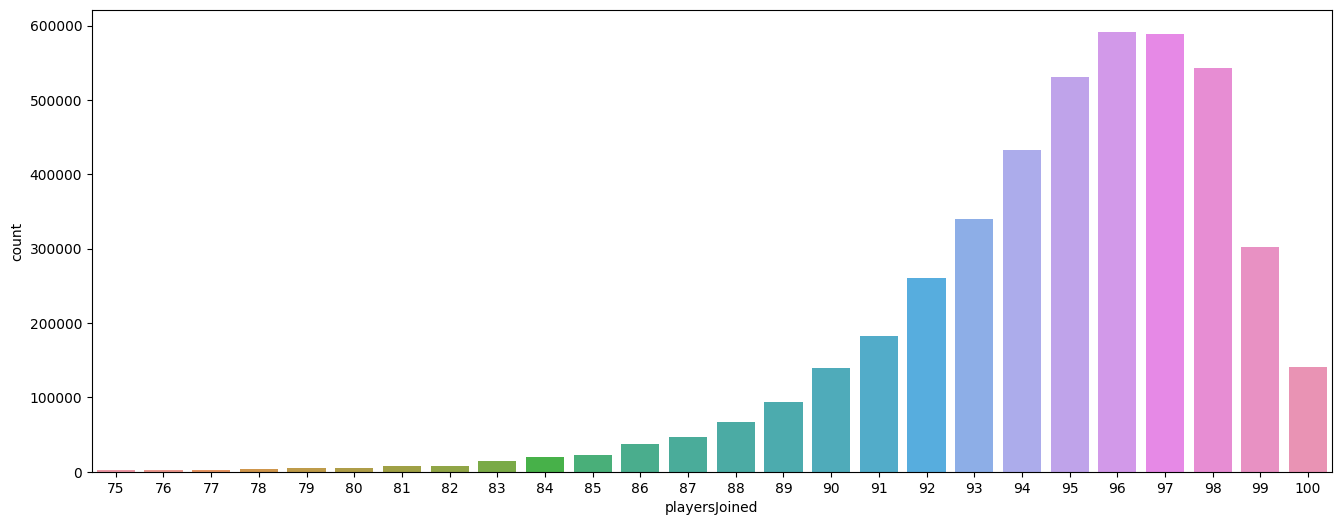

In [13]:
sns.countplot(x=df[df['playersJoined']>=75]['playersJoined'])
plt.show()

## Analysing the data

### 1. kills without Moving? 

In [14]:
## prepare a data parameter to gather the information of the total distance travelled
df['totalDistance'] = df['rideDistance'] + df['walkDistance'] + df['swimDistance']

# prepare a data parameter to check for anamoly detection that
# the person has not moved but still managed to do the kills

df['killswithoutMoving'] = ((df['kills']>0) & (df['totalDistance'] == 0))

In [15]:
df[df['killswithoutMoving'] == True].head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,playersJoined,totalDistance,killswithoutMoving
1824,b538d514ef2476,0eb2ce2f43f9d6,35e7d750e442e2,0,0,593.0,0,0,3,18,...,0.0,0,0,0.0,8,0,0.8571,58,0.0,True
6673,6d3a61da07b7cb,2d8119b1544f87,904cecf36217df,2,0,346.6,0,0,6,33,...,0.0,0,0,0.0,22,0,0.6000,42,0.0,True
11892,550398a8f33db7,c3fd0e2abab0af,db6f6d1f0d4904,2,0,1750.0,0,4,5,3,...,0.0,0,0,0.0,13,0,0.8947,21,0.0,True
14631,58d690ee461e9d,ea5b6630b33d67,dbf34301df5e53,0,0,157.8,0,0,0,69,...,0.0,0,0,0.0,7,1500,0.0000,73,0.0,True
15591,49b61fc963d632,0f5c5f19d9cc21,904cecf36217df,0,0,100.0,0,1,0,37,...,0.0,0,0,0.0,10,0,0.3000,42,0.0,True


In [16]:
df[df['killswithoutMoving'] == True].shape

(1535, 32)

In [17]:
#drop the table
df.drop(df[df['killswithoutMoving'] == True].index,inplace = True)

### 2. Extra-ordinary Road kills ???

In [18]:
df[df['roadKills']>5].shape

(46, 32)

In [19]:
df.drop(df[df['roadKills']>5].index,inplace = True)

### 3. So many kills - how ??

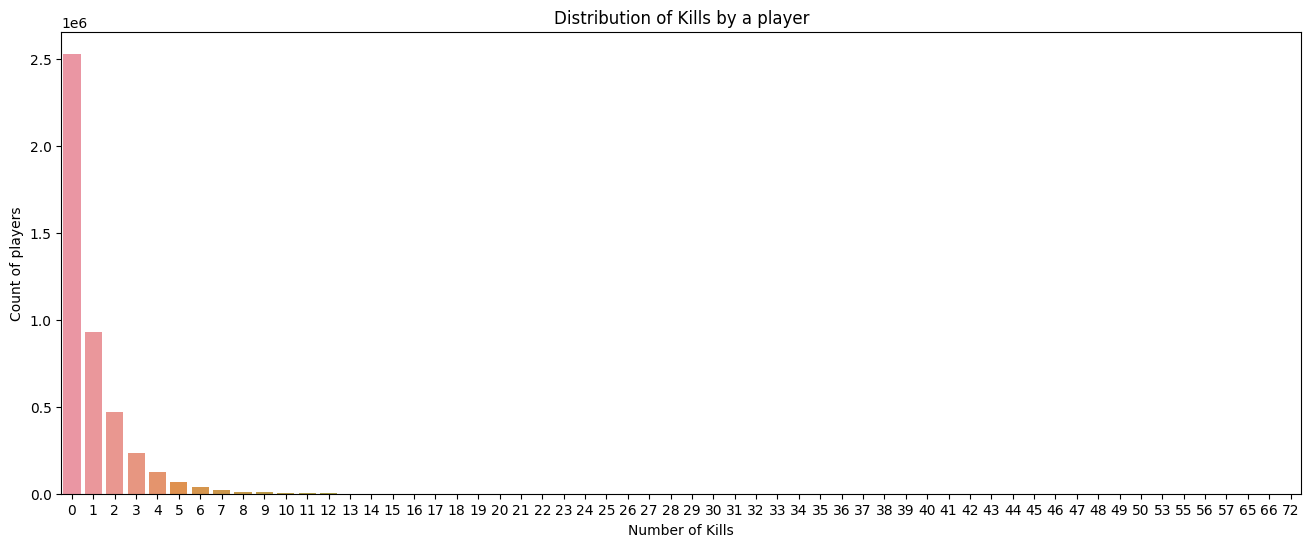

In [20]:
sns.countplot(data = df,x=df['kills']).set_title("Distribution of Kills by a player")
plt.ylabel("Count of players")
plt.xlabel("Number of Kills")
plt.show()

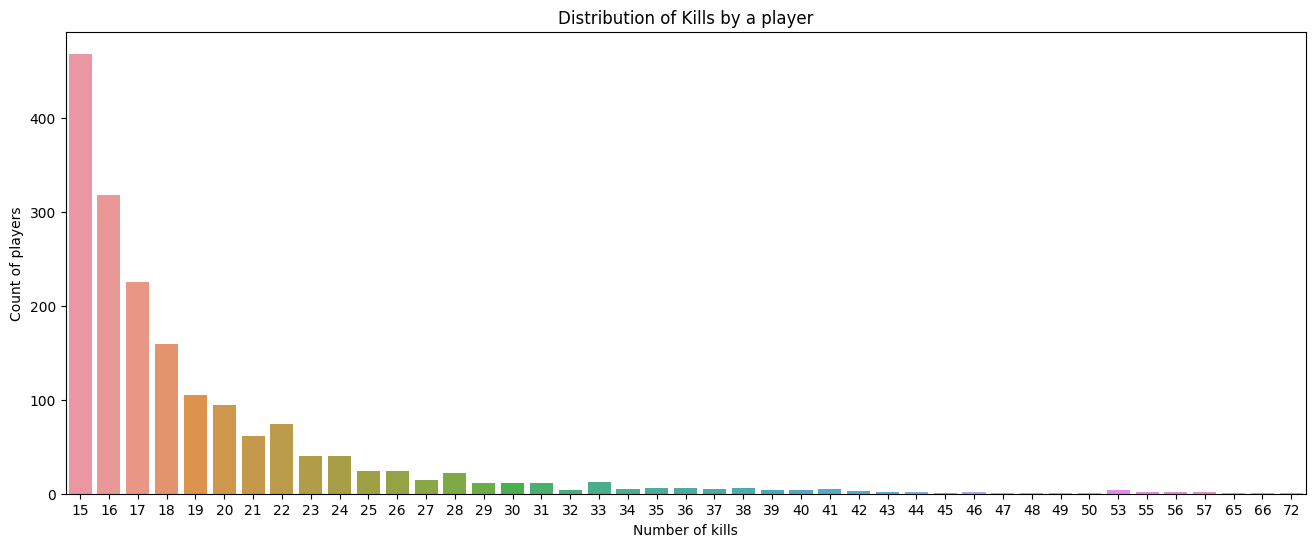

In [21]:
sns.countplot(x=df[df['kills']>=15]['kills']).set_title("Distribution of Kills by a player")
plt.ylabel("Count of players")
plt.xlabel("Number of kills")
plt.show()

In [22]:
# data dimension
df[df['kills']> 20].shape

(417, 32)

In [23]:
# drop the instances 
df.drop(df[df['kills']>20].index,inplace=True)

### 4. Head Shot

In [24]:
df['headshot_rate'] = df['headshotKills']/df['kills']
df['headshot_rate'] = df['headshot_rate'].fillna(0)

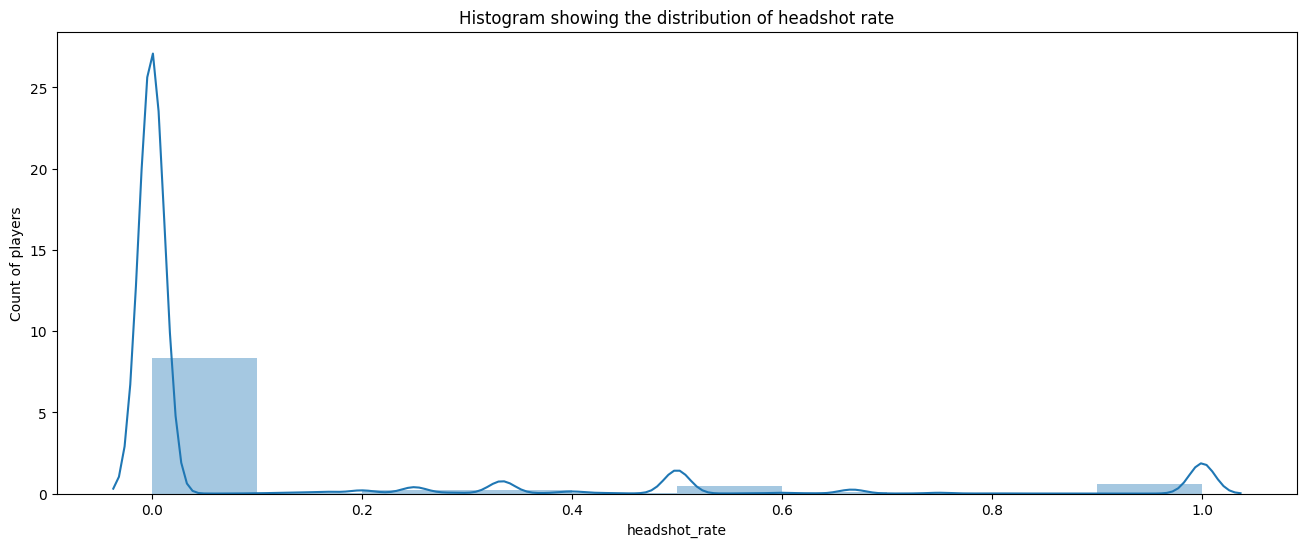

In [25]:
# plot the headshot rate distribution
sns.distplot(df['headshot_rate'],bins = 10).set_title("Histogram showing the distribution of headshot rate")
plt.ylabel("Count of players")
plt.show()

In [26]:
df[(df['headshot_rate']==1) & (df['kills']>5)].shape

(187, 33)

In [27]:
df.drop(df[(df['headshot_rate']==1) & (df['kills']>6)].index,inplace = True)

### 5. Longest Shot

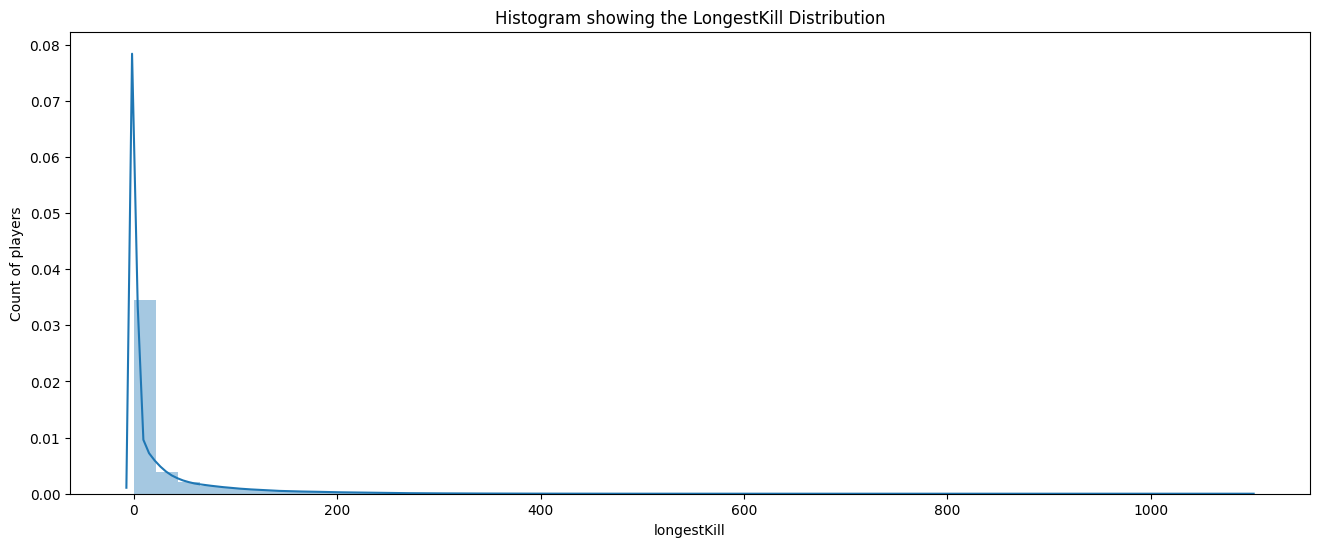

In [28]:
sns.distplot(df['longestKill'],bins = 50).set_title("Histogram showing the LongestKill Distribution")
plt.ylabel("Count of players")
plt.show()

In [29]:
df[df['longestKill']>=500].shape

(1747, 33)

In [30]:
df.drop(df[df['longestKill']>=500].index,inplace = True)

### 6. Weapon Change

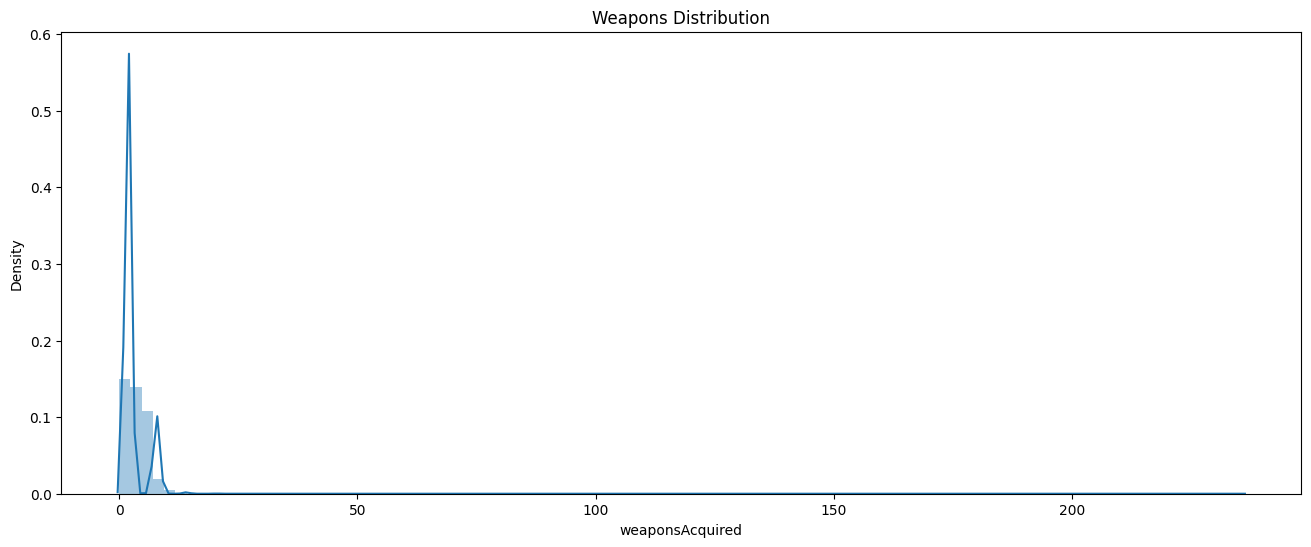

In [31]:
sns.distplot(df['weaponsAcquired'],bins=100).set_title("Weapons Distribution")
plt.show()

In [32]:
df[df['weaponsAcquired']>=15].shape

(6809, 33)

In [33]:
df.drop(df[df['weaponsAcquired']>=15].index, inplace = True)

# EDA

In [34]:
df.shape

(4436306, 33)

In [35]:
df.isna().sum()

Id                    0
groupId               0
matchId               0
assists               0
boosts                0
damageDealt           0
DBNOs                 0
headshotKills         0
heals                 0
killPlace             0
killPoints            0
kills                 0
killStreaks           0
longestKill           0
matchDuration         0
matchType             0
maxPlace              0
numGroups             0
rankPoints            0
revives               0
rideDistance          0
roadKills             0
swimDistance          0
teamKills             0
vehicleDestroys       0
walkDistance          0
weaponsAcquired       0
winPoints             0
winPlacePerc          0
playersJoined         0
totalDistance         0
killswithoutMoving    0
headshot_rate         0
dtype: int64

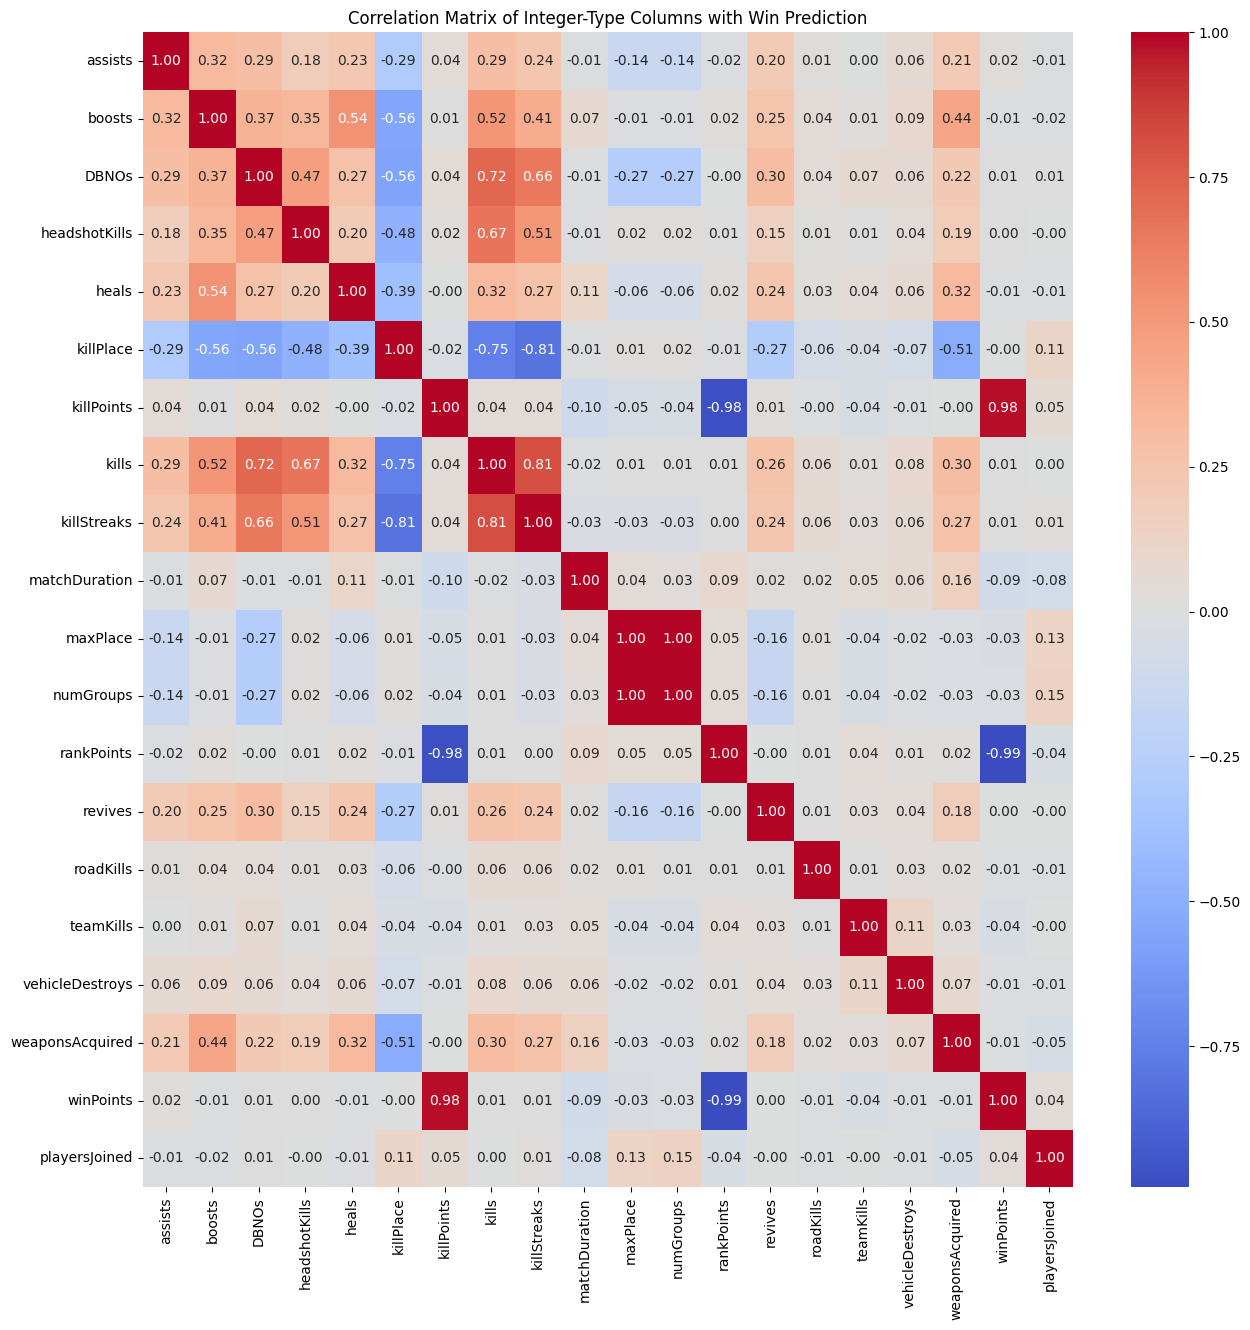

In [36]:
# correlation of parameter with Win Prediction
# Select integer-type columns
int_columns = df.select_dtypes(include='int64')

# Plot the correlation matrix heatmap
plt.figure(figsize=[15, 15])
sns.heatmap(int_columns.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Integer-Type Columns with Win Prediction')
plt.show()


# Feature Engineering

In [37]:
normalising_factor = (100 - df['playersJoined']/100)+1

In [38]:
normalising_factor

0          100.04
1          100.09
2          100.02
3          100.09
4          100.03
            ...  
4446961    100.06
4446962    100.07
4446963    100.02
4446964    100.06
4446965    100.02
Name: playersJoined, Length: 4436306, dtype: float64

In [39]:
df.columns

Index(['Id', 'groupId', 'matchId', 'assists', 'boosts', 'damageDealt', 'DBNOs',
       'headshotKills', 'heals', 'killPlace', 'killPoints', 'kills',
       'killStreaks', 'longestKill', 'matchDuration', 'matchType', 'maxPlace',
       'numGroups', 'rankPoints', 'revives', 'rideDistance', 'roadKills',
       'swimDistance', 'teamKills', 'vehicleDestroys', 'walkDistance',
       'weaponsAcquired', 'winPoints', 'winPlacePerc', 'playersJoined',
       'totalDistance', 'killswithoutMoving', 'headshot_rate'],
      dtype='object')

In [40]:
df['killsNorm'] = df['kills'] * normalising_factor
df['damageDealtNorm'] = df['damageDealt'] * normalising_factor
df['maxPlaceNorm'] = df['maxPlace'] * normalising_factor
df['matchDurationNorm'] = df['matchDuration'] * normalising_factor


df['traveldistance'] = df['walkDistance'] + df['swimDistance'] + df['rideDistance']
df['healsnboosts'] = df['heals'] + df['boosts']
df['assist'] = df['assists'] + df['revives']

In [41]:
df.columns

Index(['Id', 'groupId', 'matchId', 'assists', 'boosts', 'damageDealt', 'DBNOs',
       'headshotKills', 'heals', 'killPlace', 'killPoints', 'kills',
       'killStreaks', 'longestKill', 'matchDuration', 'matchType', 'maxPlace',
       'numGroups', 'rankPoints', 'revives', 'rideDistance', 'roadKills',
       'swimDistance', 'teamKills', 'vehicleDestroys', 'walkDistance',
       'weaponsAcquired', 'winPoints', 'winPlacePerc', 'playersJoined',
       'totalDistance', 'killswithoutMoving', 'headshot_rate', 'killsNorm',
       'damageDealtNorm', 'maxPlaceNorm', 'matchDurationNorm',
       'traveldistance', 'healsnboosts', 'assist'],
      dtype='object')

In [42]:
data = df.drop(columns = ['Id', 'groupId', 'matchId', 'assists', 'boosts', 'walkDistance', 'swimDistance', 
                          'rideDistance', 'heals', 'revives', 'kills', 'damageDealt', 'maxPlace', 'matchDuration'])

In [43]:
data.head()

,DBNOs,headshotKills,killPlace,killPoints,killStreaks,longestKill,matchType,numGroups,rankPoints,roadKills,...,totalDistance,killswithoutMoving,headshot_rate,killsNorm,damageDealtNorm,maxPlaceNorm,matchDurationNorm,traveldistance,healsnboosts,assist
0,0,0,60,1241,0,0.00,squad-fpp,26,-1,0,...,244.8000,False,0.0,0.00,0.0000,2801.12,130652.24,244.8000,0,0
1,0,0,57,0,0,0.00,squad-fpp,25,1484,0,...,1445.0445,False,0.0,0.00,9155.2323,2602.34,177859.93,1445.0445,0,0
2,0,0,47,0,0,0.00,duo,47,1491,0,...,161.8000,False,0.0,0.00,6801.3600,5001.00,131826.36,161.8000,0,1
3,0,0,75,0,0,0.00,squad-fpp,30,1408,0,...,202.7000,False,0.0,0.00,3292.9610,3102.79,143729.24,202.7000,0,0
4,0,0,45,0,1,58.53,solo-fpp,95,1560,0,...,49.7500,False,0.0,100.03,10003.0000,9702.91,142442.72,49.7500,0,0


## Ml- Catboost Model

### 1. Handling the categorical data

In [44]:
x = data.drop(['winPlacePerc'],axis = 1)
y = data['winPlacePerc']

In [45]:
x.head()

,DBNOs,headshotKills,killPlace,killPoints,killStreaks,longestKill,matchType,numGroups,rankPoints,roadKills,...,totalDistance,killswithoutMoving,headshot_rate,killsNorm,damageDealtNorm,maxPlaceNorm,matchDurationNorm,traveldistance,healsnboosts,assist
0,0,0,60,1241,0,0.00,squad-fpp,26,-1,0,...,244.8000,False,0.0,0.00,0.0000,2801.12,130652.24,244.8000,0,0
1,0,0,57,0,0,0.00,squad-fpp,25,1484,0,...,1445.0445,False,0.0,0.00,9155.2323,2602.34,177859.93,1445.0445,0,0
2,0,0,47,0,0,0.00,duo,47,1491,0,...,161.8000,False,0.0,0.00,6801.3600,5001.00,131826.36,161.8000,0,1
3,0,0,75,0,0,0.00,squad-fpp,30,1408,0,...,202.7000,False,0.0,0.00,3292.9610,3102.79,143729.24,202.7000,0,0
4,0,0,45,0,1,58.53,solo-fpp,95,1560,0,...,49.7500,False,0.0,100.03,10003.0000,9702.91,142442.72,49.7500,0,0


In [46]:
x = pd.get_dummies(x, columns = ['matchType', 'killswithoutMoving'])

In [47]:
x.head()

,DBNOs,headshotKills,killPlace,killPoints,killStreaks,longestKill,numGroups,rankPoints,roadKills,teamKills,...,matchType_normal-duo-fpp,matchType_normal-solo,matchType_normal-solo-fpp,matchType_normal-squad,matchType_normal-squad-fpp,matchType_solo,matchType_solo-fpp,matchType_squad,matchType_squad-fpp,killswithoutMoving_False
0,0,0,60,1241,0,0.00,26,-1,0,0,...,False,False,False,False,False,False,False,False,True,True
1,0,0,57,0,0,0.00,25,1484,0,0,...,False,False,False,False,False,False,False,False,True,True
2,0,0,47,0,0,0.00,47,1491,0,0,...,False,False,False,False,False,False,False,False,False,True
3,0,0,75,0,0,0.00,30,1408,0,0,...,False,False,False,False,False,False,False,False,True,True
4,0,0,45,0,1,58.53,95,1560,0,0,...,False,False,False,False,False,False,True,False,False,True


In [48]:
x = x.astype(int)

In [49]:
x.head()

,DBNOs,headshotKills,killPlace,killPoints,killStreaks,longestKill,numGroups,rankPoints,roadKills,teamKills,...,matchType_normal-duo-fpp,matchType_normal-solo,matchType_normal-solo-fpp,matchType_normal-squad,matchType_normal-squad-fpp,matchType_solo,matchType_solo-fpp,matchType_squad,matchType_squad-fpp,killswithoutMoving_False
0,0,0,60,1241,0,0,26,-1,0,0,...,0,0,0,0,0,0,0,0,1,1
1,0,0,57,0,0,0,25,1484,0,0,...,0,0,0,0,0,0,0,0,1,1
2,0,0,47,0,0,0,47,1491,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,75,0,0,0,30,1408,0,0,...,0,0,0,0,0,0,0,0,1,1
4,0,0,45,0,1,58,95,1560,0,0,...,0,0,0,0,0,0,1,0,0,1


In [50]:
x.shape

(4436306, 40)

In [51]:
features = x.columns

## Scaling the data

In [52]:
sc = StandardScaler()
sc.fit(x)
x = pd.DataFrame(sc.transform(x))

In [53]:
x.head()

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,-0.582937,-0.384018,0.449345,1.172485,-0.765100,-0.456475,-0.732886,-1.212390,-0.049567,-0.142509,...,-0.033604,-0.005244,-0.013803,-0.008292,-0.054367,-0.206514,-0.370797,-0.405071,1.236192,0.0
1,-0.582937,-0.384018,0.340055,-0.804728,-0.765100,-0.456475,-0.775859,0.803564,-0.049567,-0.142509,...,-0.033604,-0.005244,-0.013803,-0.008292,-0.054367,-0.206514,-0.370797,-0.405071,1.236192,0.0
2,-0.582937,-0.384018,-0.024245,-0.804728,-0.765100,-0.456475,0.169557,0.813067,-0.049567,-0.142509,...,-0.033604,-0.005244,-0.013803,-0.008292,-0.054367,-0.206514,-0.370797,-0.405071,-0.808936,0.0
3,-0.582937,-0.384018,0.995795,-0.804728,-0.765100,-0.456475,-0.560992,0.700391,-0.049567,-0.142509,...,-0.033604,-0.005244,-0.013803,-0.008292,-0.054367,-0.206514,-0.370797,-0.405071,1.236192,0.0
4,-0.582937,-0.384018,-0.097105,-0.804728,0.647633,0.722626,2.232284,0.906738,-0.049567,-0.142509,...,-0.033604,-0.005244,-0.013803,-0.008292,-0.054367,-0.206514,2.696896,-0.405071,-0.808936,0.0


### Splitting data

In [54]:
xtrain,xtest,ytrain,ytest = train_test_split(x,y,test_size=0.3,random_state=0)

In [55]:
print(xtrain.shape,ytrain.shape)
print(xtest.shape,ytest.shape)

(3105414, 40) (3105414,)
(1330892, 40) (1330892,)


# CatBoost Model

In [56]:
import catboost as cb

In [57]:
train_dataset = cb.Pool(xtrain,ytrain)
test_dataset = cb.Pool(xtest,ytest)

In [58]:
model = cb.CatBoostRegressor(loss_function = 'RMSE')

In [59]:
## GRID Search
grid = {'iterations':[100,150],
       'learning_rate':[0.03,0.1],
       'depth':[2,4,6,8]}

model.grid_search(grid,train_dataset)

0:	learn: 0.5481788	test: 0.5479666	best: 0.5479666 (0)	total: 352ms	remaining: 34.8s
1:	learn: 0.5333400	test: 0.5331414	best: 0.5331414 (1)	total: 529ms	remaining: 25.9s
2:	learn: 0.5189698	test: 0.5187772	best: 0.5187772 (2)	total: 712ms	remaining: 23s
3:	learn: 0.5050417	test: 0.5048539	best: 0.5048539 (3)	total: 897ms	remaining: 21.5s
4:	learn: 0.4915988	test: 0.4914211	best: 0.4914211 (4)	total: 1.07s	remaining: 20.3s
5:	learn: 0.4785788	test: 0.4784101	best: 0.4784101 (5)	total: 1.24s	remaining: 19.5s
6:	learn: 0.4659787	test: 0.4658165	best: 0.4658165 (6)	total: 1.41s	remaining: 18.7s
7:	learn: 0.4538146	test: 0.4536611	best: 0.4536611 (7)	total: 1.58s	remaining: 18.2s
8:	learn: 0.4420292	test: 0.4418807	best: 0.4418807 (8)	total: 1.76s	remaining: 17.8s
9:	learn: 0.4305920	test: 0.4304483	best: 0.4304483 (9)	total: 1.93s	remaining: 17.4s
10:	learn: 0.4195627	test: 0.4194256	best: 0.4194256 (10)	total: 2.11s	remaining: 17.1s
11:	learn: 0.4088868	test: 0.4087553	best: 0.4087553 (

{'params': {'depth': 8, 'iterations': 150, 'learning_rate': 0.1},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,
               46,
    

In [60]:
feature_importance_df = pd.DataFrame()
feature_importance_df['features'] = features
feature_importance_df['importance'] = model.feature_importances_

feature_importance_df = feature_importance_df.sort_values(by = ['importance'],ascending=False)

In [61]:
feature_importance_df

,features,importance
2,killPlace,40.911562
14,totalDistance,14.412442
16,killsNorm,10.949447
20,traveldistance,10.078478
4,killStreaks,5.609835
19,matchDurationNorm,5.160175
13,playersJoined,4.841522
6,numGroups,1.859912
21,healsnboosts,1.826674
0,DBNOs,1.126172


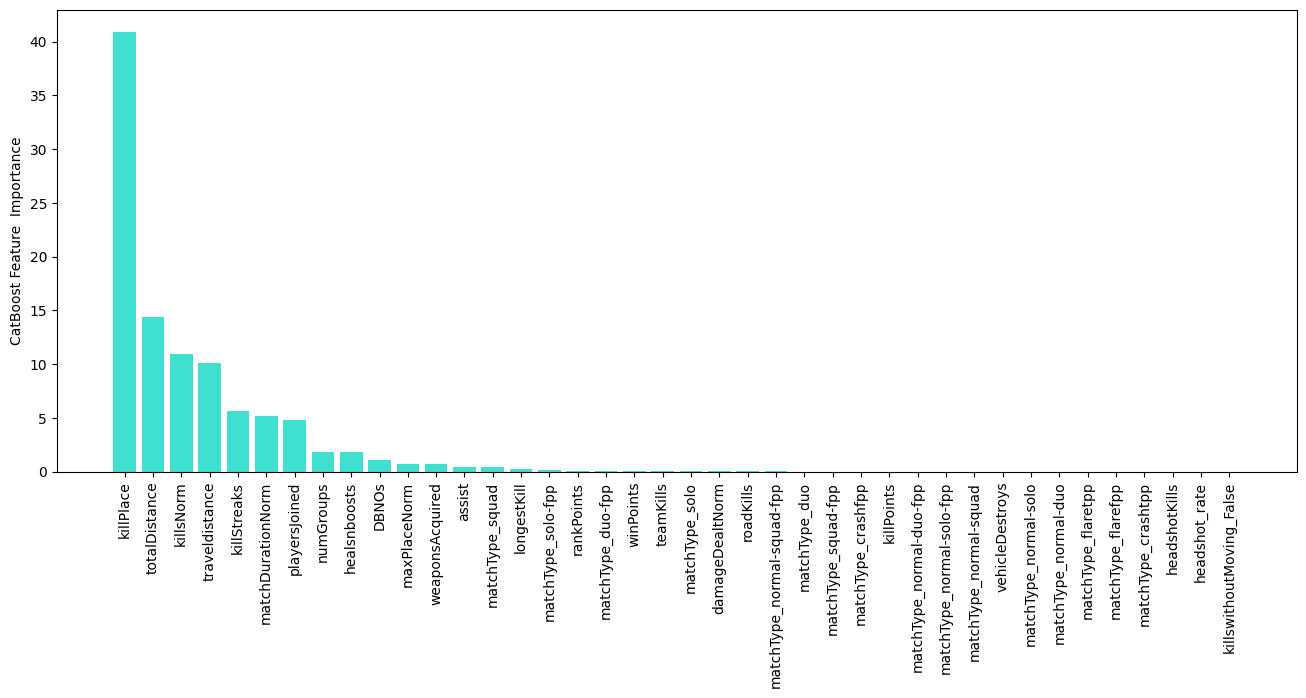

In [63]:
plt.bar(feature_importance_df.features,feature_importance_df.importance,color='turquoise')
plt.ylabel("CatBoost Feature  Importance")
plt.xticks(rotation = 90)
plt.show()

## Prediction

In [64]:
pred = model.predict(xtest)

In [65]:
ytest[:10]

2744392    0.1154
588225     0.0000
234695     0.6538
733635     0.8864
4321842    0.9896
3502031    0.0000
1954991    0.2143
4113203    0.3696
3378367    0.5333
2228830    0.1978
Name: winPlacePerc, dtype: float64

In [66]:
pred[:10]

array([0.06719968, 0.02079682, 0.5201669 , 0.80454388, 0.84996329,
       0.02051171, 0.25023582, 0.36735165, 0.70025595, 0.16737907])

In [67]:
rmse = np.sqrt(mean_squared_error(ytest,pred))
r2 = r2_score(ytest,pred)

print("Testing performance")
print("RSME: {:.2f}".format(rmse))
print("R2: {:.2f}".format(r2))

Testing performance
RSME: 0.08
R2: 0.93
